In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

In [10]:
df = pd.read_csv("ml_data/ml_ncp_rd.csv")
df.head()

,gain,offset,resolution,position,stability,target
0,2,32596093,-1.155629,-0.000714,11.789668,1
1,2,17335638,-0.960530,-0.001851,9.515574,0
2,1,17703438,-0.648550,-0.005348,9.171631,0
3,2,19586978,-1.078407,-0.000589,10.665439,0
4,2,19316614,-0.372600,-0.005060,9.446601,0


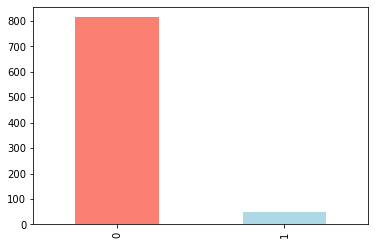

In [11]:
df["target"].value_counts().plot(kind='bar', color=['salmon','lightblue']);

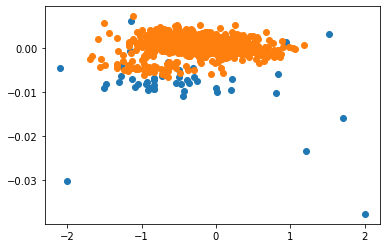

In [12]:
plt.scatter(df.resolution[df.target==1],df.position[df.target==1]);
plt.scatter(df.resolution[df.target==0],df.position[df.target==0]);

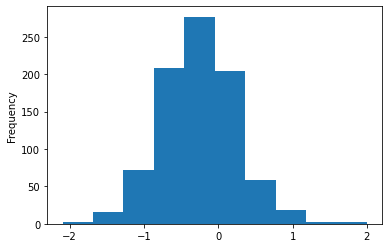

In [13]:
df.resolution.plot.hist();

In [260]:
df.corr()

,gain,offset,resolution,position,stability,target
gain,1.000000,-0.030275,0.118176,-0.035343,0.105467,0.068113
offset,-0.030275,1.000000,0.024660,0.275058,0.167949,0.031733
resolution,0.118176,0.024660,1.000000,-0.071194,-0.030214,0.078897
position,-0.035343,0.275058,-0.071194,1.000000,0.039640,0.039613
stability,0.105467,0.167949,-0.030214,0.039640,1.000000,-0.106496
target,0.068113,0.031733,0.078897,0.039613,-0.106496,1.000000


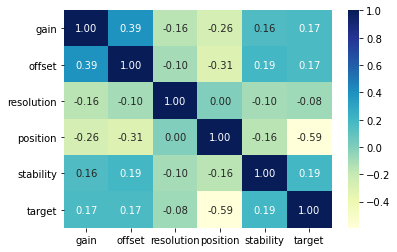

In [14]:
corr_matrix = df.corr()
fig, ax = plt.subplots()
ax = sns.heatmap(corr_matrix, annot = True, fmt = ".2f",cmap = "YlGnBu")

In [15]:
X = df.drop("target", axis=1)
y = df.target


In [16]:
np.random.seed(42)
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.2)

In [17]:
models = {"Logistic Regression":LogisticRegression(),
           "KNN":KNeighborsClassifier(),
           "Random Forest":RandomForestClassifier()}
modelss = { "KNN":KNeighborsClassifier(),
           "Random Forest":RandomForestClassifier()}

In [18]:
def fit_and_score(models, X_train,X_test,y_train,y_test):
    np.random.seed(42)
    model_scores = {}
    for name, model in models.items():
        model.fit(X_train,y_train)
        model_scores[name] = model.score(X_test,y_test)
    return model_scores    

In [19]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)
model_scores

{'Logistic Regression': 0.9595375722543352,
 'KNN': 0.953757225433526,
 'Random Forest': 0.976878612716763}

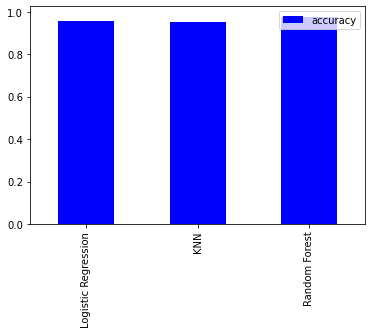

In [20]:
model_compare = pd.DataFrame(model_scores, index=["accuracy"])
model_compare.T.plot.bar(color="blue");

## Lets tune KNN

In [21]:
train_scores = []
test_scores = []
neighbors = range(1,21)
knn=KNeighborsClassifier()
for i in neighbors:
    knn.set_params(n_neighbors=i)
    knn.fit(X_train,y_train)
    train_scores.append(knn.score(X_train,y_train))
    test_scores.append(knn.score(X_test,y_test))

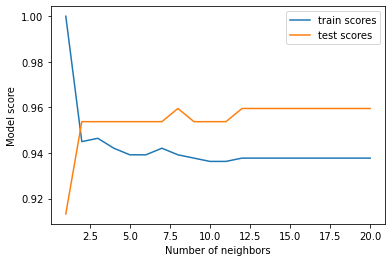

In [22]:
plt.plot(neighbors,train_scores,label='train scores')
plt.plot(neighbors,test_scores,label='test scores')
plt.xlabel("Number of neighbors")
plt.ylabel("Model score")
plt.legend();

## Hyperparametr tuning with RandomizedSearchCV

In [23]:
log_reg_grid = {"C":np.logspace(-4,4,20),
                "solver":["liblinear"]}
rf_grid = {"n_estimators":np.arange(10,1000,50),
            "max_depth":[None,3,5,10],
            "min_samples_split":np.arange(2,20,2),
            "min_samples_leaf":np.arange(1,20,2)}

In [24]:
np.random.seed(42)
rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                                param_distributions = log_reg_grid,
                                 cv = 5,
                                 n_iter=20,
                                 verbose=True)
rs_log_reg.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=True)

In [25]:
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 0.0001}

In [26]:
rs_log_reg.score(X_test,y_test)

0.9595375722543352

In [27]:
np.random.seed(42)
rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                          param_distributions=rf_grid,
                          cv = 5,
                          n_iter=20,
                          verbose=True)
rs_rf.fit(X_train,y_train)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.3min finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [28]:
rs_rf.best_params_

{'n_estimators': 510,
 'min_samples_split': 14,
 'min_samples_leaf': 1,
 'max_depth': None}

In [29]:
rs_rf.score(X_test,y_test)

0.976878612716763

## Tune Hyper Parameters using GridSearchCV

In [30]:
log_reg_grid = {"C":np.logspace(-4,4,30),
                 "solver":["liblinear"]}
gs_log_reg = GridSearchCV(LogisticRegression(),
                         param_grid = log_reg_grid,
                         cv = 5,
                         verbose=True)

In [31]:
gs_log_reg.fit(X_train,y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.2s finished


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 1.88739182e-04, 3.56224789e-04, 6.72335754e-04,
       1.26896100e-03, 2.39502662e-03, 4.52035366e-03, 8.53167852e-03,
       1.61026203e-02, 3.03919538e-02, 5.73615251e-02, 1.08263673e-01,
       2.04335972e-01, 3.85662042e-01, 7.27895384e-01, 1.37382380e+00,
       2.59294380e+00, 4.89390092e+00, 9.23670857e+00, 1.74332882e+01,
       3.29034456e+01, 6.21016942e+01, 1.17210230e+02, 2.21221629e+02,
       4.17531894e+02, 7.88046282e+02, 1.48735211e+03, 2.80721620e+03,
       5.29831691e+03, 1.00000000e+04]),
                         'solver': ['liblinear']},
             verbose=True)

In [32]:
gs_log_reg.best_params_

{'C': 0.0001, 'solver': 'liblinear'}

In [33]:
gs_log_reg.score(X_test,y_test)

0.9595375722543352

In [34]:
y_preds = gs_log_reg.predict(X_test)

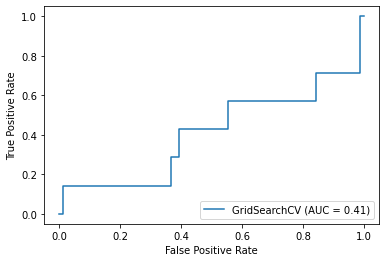

In [35]:
plot_roc_curve(gs_log_reg, X_test,y_test);

In [36]:
print (confusion_matrix(y_test,y_preds))

[[166   0]
 [  7   0]]


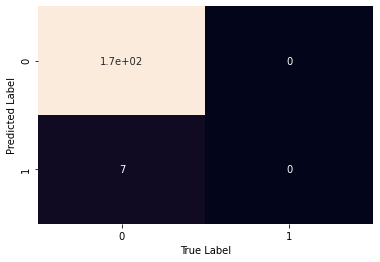

In [37]:
def plot_conf_mat(y_test,y_preds):
    fig, ax = plt.subplots()
    ax = sns.heatmap(confusion_matrix(y_test,y_preds),
                    annot = True,
                    cbar=False)
    plt.xlabel("True Label")
    plt.ylabel("Predicted Label")
    
plot_conf_mat(y_test,y_preds)    

In [38]:
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       166
           1       0.00      0.00      0.00         7

    accuracy                           0.96       173
   macro avg       0.48      0.50      0.49       173
weighted avg       0.92      0.96      0.94       173



C:\Users\10234\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\Users\10234\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\10234\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\10234\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\10234\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 

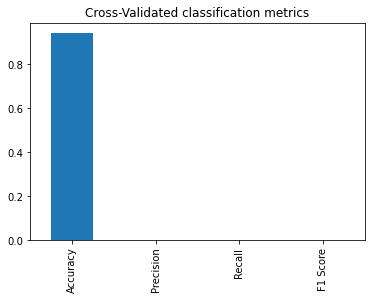

In [39]:
clf = LogisticRegression(C=0.204333, solver="liblinear")
cv_acc = cross_val_score(clf,X,y,cv=5,scoring="accuracy")
cv_acc = np.mean(cv_acc)
cv_precision = cross_val_score(clf,X,y,cv=5,scoring="precision")
cv_precision = np.mean(cv_precision)
cv_recall = cross_val_score(clf,X,y,cv=5,scoring="recall")
cv_recall = np.mean(cv_recall)
cv_f1 = cross_val_score(clf,X,y,cv=5,scoring="f1")
cv_f1 = np.mean(cv_f1)

cv_metrics = pd.DataFrame({"Accuracy":cv_acc,
                           "Precision":cv_precision,
                           "Recall":cv_recall,
                            "F1 Score":cv_f1}, index=[0])
cv_metrics.T.plot.bar(title="Cross-Validated classification metrics", legend=False);

In [40]:
gs_log_reg.best_params_

{'C': 0.0001, 'solver': 'liblinear'}

In [41]:
clf = LogisticRegression(C= 0.20433597178569418, solver="liblinear")

In [42]:
clf.fit(X_train,y_train);

In [43]:
clf.coef_

array([[-2.91612120e-17, -1.47434484e-07,  1.48946712e-16,
        -9.06304116e-17, -6.59495462e-14]])

In [44]:
feature_dict = dict(zip(df.columns,list(clf.coef_[0])))
feature_dict

{'gain': -2.916121196271181e-17,
 'offset': -1.4743448447016295e-07,
 'resolution': 1.4894671184019426e-16,
 'position': -9.063041164792796e-17,
 'stability': -6.59495462182743e-14}

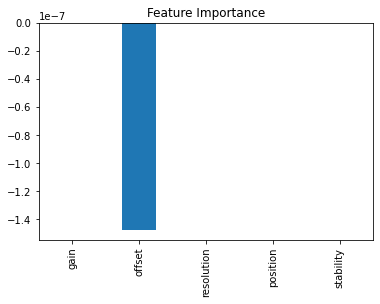

In [45]:
feature_df = pd.DataFrame(feature_dict,index=[0])
feature_df.T.plot.bar(title="Feature Importance", legend=False);